In [1]:
# obligatory import statements
from sympy import symbols, log, sqrt, Piecewise
from sympy.functions import Abs
from sympy.plotting import plot
from matplotlib import pyplot as pl

# Choosing a loss function for regression 

With the regression data frame analytics jobs we now support three different loss functions: `mse`, `msle`, and `huber`. While all three of them can be used to train a model to predict real-valued data by minimizing average loss between actual values $a_i$ and predictions $p_i$
$$\frac{1}{N}\sum_{i=1}^{N}L(a_i,p_i),$$
they would work best in different scenarios. Let's look at what loss function works best for which case. 

## Mean squared error (MSE)

[MSE](https://en.wikipedia.org/wiki/Mean_squared_error) if the most commonly used loss function. It works sufficiently well in many scenarios and you should try it if you are unsure or you don't know much about your data. 

As the name suggests, MSE minimizes the quadratic difference between the prediction and the actual value:
$$L(a_i,p_i) = \tfrac{1}{2}(a_i-p_i)^2$$

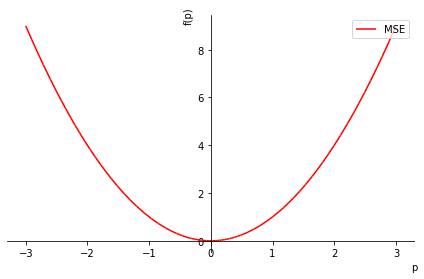

In [2]:
a = symbols('a') #actual value
p = symbols('p') #predicted value
mse = lambda a,p: (a-p)**2
mse_plot = plot(mse(0, p),(p, -3, 3), show=False, legend=True, line_color="red")
mse_plot[0].label='MSE'
mse_plot.show()

The problem with the squared error is that it makes small errors (< 1.0) even smaller and large large errors (>1.0) disproportionately larger.

This means that if you have a few outliers in your data, i.e. due to a large measurement error, the model will put useless effort to fit these data points and other points will fall by the wayside. 

So what you often want to do is instead of fitting the mean **squared** error to fit the mean **absolute** error (MAE)
$$L(a_i,p_i) = \vert a_i - p_i\vert^2$$

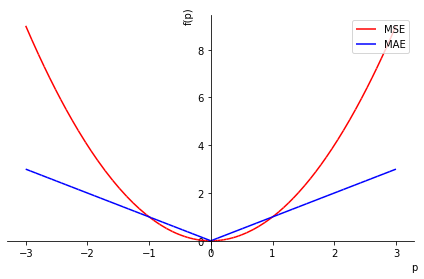

In [3]:
mae = lambda a,p: Abs(a-p)
mae_plot = plot(mae(0, p),(p, -3, 3), show=False, line_color="blue")
mae_plot[0].label = "MAE"
mse_plot.extend(mae_plot)
mse_plot.show()

MAE does not over-prioritize outliers and it is easy to interpret: mean absolute error of 20\\$ on price prediction means that you are on average 20\\$ off your target mark in one way or another.

Unfortunately, it is not straight forward to train models on MAE using conventional algorithms because of the sharp kink around `0.0`. So what you actually want is a loss function that behaves as MAE for errors larger than 1 and as MSE for errors smaller than 1. This loss function is called [Huber loss](https://en.wikipedia.org/wiki/Huber_loss).

## Huber loss

Generally, Huber loss uses a parameter $\delta$ to define the transition point between MSE and MAE:
$$L(a, p) = \left\{\begin{aligned}
\tfrac{1}{2}(a-p)^2 \quad\mathrm{for}\ |a-p| \le \delta \\
\delta\vert a - p \vert - \tfrac{1}{2}\delta^2 \quad\mathrm{otherwise}
\end{aligned}\right.
$$

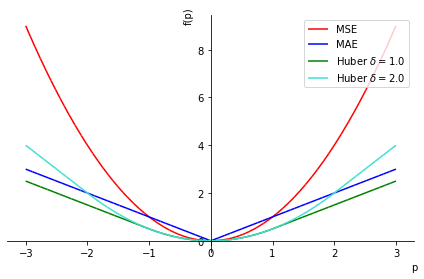

In [4]:
huber = lambda delta,a,p: Piecewise((0.5*(a-p)**2, Abs(a-p) <= delta), (delta*Abs(a-p)-0.5*delta**2, True))
huber1_plot = plot(huber(1.0, 0, p),(p, -3, 3), show=False, line_color="green")
huber1_plot[0].label = "Huber $\delta=1.0$"
huber2_plot = plot(huber(2.0, 0, p),(p, -3, 3), show=False, line_color="turquoise")
huber2_plot[0].label = "Huber $\delta=2.0$"
mse_plot.extend(huber1_plot)
mse_plot.extend(huber2_plot)
mse_plot.show()

Particularly interesting is that for $\delta=1.0$ Huber loss is asymptotically similar to MAE and behaves as MSE around 0. For other values of $\delta$, Huber loss will still increase linearly for large errors and $\delta$ controls simply the slope of this growth. 

In machine learning data frame analytics we implemented the so-called [Pseudo-Huber loss](https://en.wikipedia.org/wiki/Huber_loss#Pseudo-Huber_loss_function)
$$L(a_i,p_i) = \delta^2 \left(\sqrt{1+((a_i-p_i)/\delta)^2}-1\right).$$

This results in faster code while keeping the properties of the normal Huber loss.

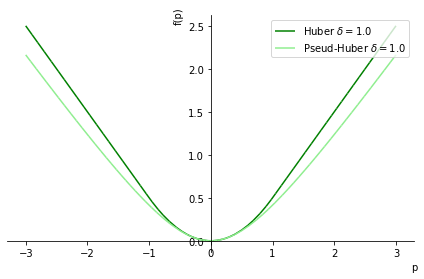

In [5]:
pseudo_huber = lambda delta,a,p: delta**2*(sqrt(1+((a-p)/delta)**2)-1)
pseudo_huber1 = plot(pseudo_huber(1.0, 0,p),(p, -3, 3), show=False, legend=True, line_color='lightgreen')
pseudo_huber1[0].label='Pseud-Huber $\delta=1.0$'
huber1_plot.extend(pseudo_huber1)
huber1_plot.legend = True
huber1_plot.show()

### Conclusion 

To use Huber loss with a certain parameter $\delta$ in your data frame analytics regression job, you can specify parameter `loss_function` (set it to `huber`) and `loss_function_parameter`. Use Huber loss if you have outliers in your data coming from measurement errors. You can experiment with different values of $\delta$, also the default value 1.0 should be fine for most cases.

## Mean squared logarithmic error (MSLE)

This loss function is used when you have positive targets distributed with a long tail such as log-normal distribution. There are [numerous examples](https://en.wikipedia.org/wiki/Log-normal_distribution#Occurrence_and_applications) of such data: house pricing, income of private households, city population, etc.


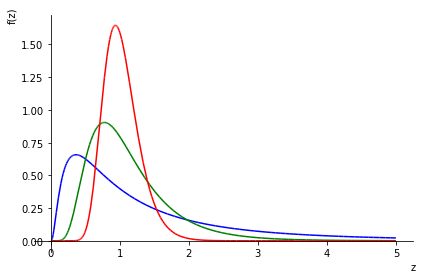

In [6]:
from sympy.stats import LogNormal, density
z = symbols('z')
log_norm_1 = LogNormal("x", 0, 1.0)
log_norm_2 = LogNormal("x", 0, 0.5)
log_norm_3 = LogNormal("x", 0, 0.25)
pdf_plot1= plot(density(log_norm_1)(z), (z,0.01, 5), show=False, line_color="blue")
pdf_plot2= plot(density(log_norm_2)(z), (z,0.01, 5), show=False, line_color="green")
pdf_plot3= plot(density(log_norm_3)(z), (z,0.01, 5), show=False, line_color="red")
pdf_plot1.extend(pdf_plot2)
pdf_plot1.extend(pdf_plot3)
pdf_plot1.show()



The distribution of the values has a "bump" for smaller values and then a long tail with a small number of very large values. 

Naturally, when we want to predict the target values, we want to allow for an error depending on the magnitude of the target. It’s ok to miss a population of a metropolitan area by 10 000, but for a small town it is unforgivable. In this case MSLE can be more suitable for the regression job than MSE. As the name suggests, MSLE minimizes the quadratic difference between the logarithms of the actual value and the prediction
$$L(a_i, p_i) = (\log(a_i + t) - \log(p_i + t))^2$$

Qualitatively speaking, MSLE tends to lead to lower error for small targets and for higher error on large targets than MSE. This trade-off can be controlled by adjusting an offset parameter $t$ which is set to 1.0 by default. By increasing this parameter we influence the “transition point” at which we go from minimizing quadratic error to minimizing quadratic log error. 

Let's take a look how this offset affects quantitative results.

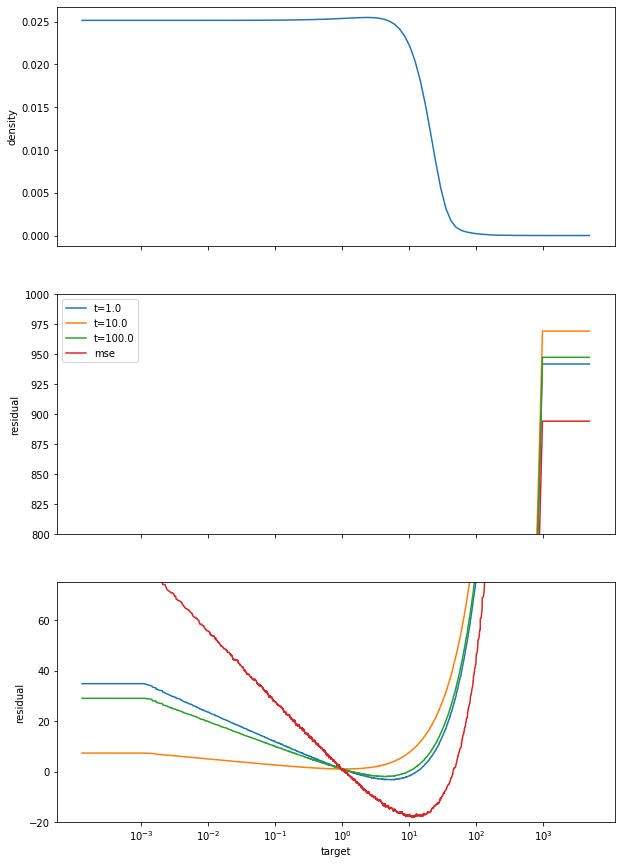

In [7]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from scipy.optimize import minimize
from scipy.ndimage import median_filter
from scipy.stats.kde import gaussian_kde

# We generate random data and train a simple linear model to minimize
# MSE and MSLE loss functions.
np.random.seed(1000)
N = 10000
nbins = N//10
w = np.ones(5)
X = np.random.randn(N, 5)
y = X.dot(w)
yexp = np.exp(y)

mse = lambda x: mean_squared_error(yexp, X.dot(x))
def msle(x, t=1): 
    pred = X.dot(x)+t
    pred[pred<0] = 0
    return mean_squared_log_error(yexp+t, pred)

x0 = np.zeros(X.shape[1]) #initial guess
res_mse = minimize(mse, x0, tol=1e-5) #MSE residuals
results = {} #MSLE residuals for different offsets
T = [1.0, 10.0, 100.0]
for t in T:
    results[t] = minimize(lambda x: msle(x, t), x0, tol=1e-5)

sorted_idx = np.argsort(yexp)
label_sorted = yexp[sorted_idx]
def get_sorted_residuals(results):
    residuals = yexp - X.dot(results['x'])
    return residuals[sorted_idx]

f, (axTop, axMiddle, axBottom) = pl.subplots(3, 1, sharex=True, figsize=(10, 15))

# plot the density distribution of the target values on top
kde = gaussian_kde(yexp)
yrange = np.logspace(min(y), max(y), 100, base=np.exp(1))
axTop.plot(yrange, kde(yrange))
axTop.set_ylabel('density')

# plot the magnitudes of residuals for MSE and MSLE with different offsets
for t in T:
    # use a median filter to smooth residuals and see the trend.
    axMiddle.plot(label_sorted, median_filter(get_sorted_residuals(results[t]),  size=50), label='t={}'.format(t))
    axBottom.plot(label_sorted, median_filter(get_sorted_residuals(results[t]),  size=50), label='t={}'.format(t))                        
axMiddle.plot(label_sorted, median_filter(get_sorted_residuals(res_mse),  size=50), label='mse')
axBottom.plot(label_sorted, median_filter(get_sorted_residuals(res_mse),  size=50), label='mse')

axBottom.set_xscale('log')
axBottom.set_xlabel('target')
axBottom.set_xticks(np.logspace(-3,3,7))
axMiddle.set_ylabel('residual')
axBottom.set_ylabel('residual')
axMiddle.set_ylim(800,1000)
axBottom.set_ylim(-20,75)
axMiddle.legend()

pl.show()

Note that I broke the y-axis in the bottom diagrams to be able to see those small residuals!

First, MSE tends to result in larger errors for small target values despite the fact that most of the targets are rather small. It rather focuses on producing smaller errors for large target values.

Second, if we look at the density of the target values (top diagram), we see that qualitatively the "transition point" happens somewhere around 10: we have a high concentration of small targets <10 and low number of targets >>10. Quantitatively, this "transition point" is somewhere between 80th and 90th percentile. 

In [8]:
quantiles = np.linspace(0, 1.0, 11)
qvalues = np.quantile(yexp, np.linspace(0, 1.0, 11))
for q, val in zip(quantiles, qvalues):
    print("Percentile {:.0f}\tvalue {:.2f}".format(q*100, val))

Percentile 0	value 0.00
Percentile 10	value 0.06
Percentile 20	value 0.15
Percentile 30	value 0.31
Percentile 40	value 0.54
Percentile 50	value 0.96
Percentile 60	value 1.74
Percentile 70	value 3.10
Percentile 80	value 6.18
Percentile 90	value 16.46
Percentile 100	value 4891.30


Setting the offset parameter to 1.0 or 100.0 undershoots and overshoots this "transition point". Both lead to similar results with greater residuals for small targets and lower residuals for large targets compared to the offset parameter of 10.0. However, trying to "nail" the correct transition point super exactly is not worth it: setting offset parameter to 6.0 or 16.0  won't change the results significantly compared to 10.0.

### Conclusion

To use MSLE with a certain parameter offset $t$ in your data frame analytics regression job, you can specify parameter `loss_function` (set it to `msle`) and `loss_function_parameter`. Try it, if you have one of the [numerous examples](https://en.wikipedia.org/wiki/Log-normal_distribution#Occurrence_and_applications) of positive target values which scale over a large scale. You can leave the `loss_function_parameter` as it is, but if you want to experiment with different offset values, we recommend to set the value somewhere at the 80th percentile of the target distribution and then increase by an order of magnitude and look at the results qualitatively.